In [1]:
import pandas as pd
import numpy as np
import math
from  datetime  import  *  
import  time 
import requests 
import re
from bs4 import BeautifulSoup as bs
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fundcode = ["005004","004997","570001","110022","006228","519674","006751","001410","001156","001475","003625","004424","164906","270042","005827","260108","005968","001641"]
startdate = "2019-3-29"
Rf = 0.02375/250

In [6]:
today = time.strftime("%Y-%m-%d")
pages = int((pd.to_datetime(today)-pd.to_datetime(startdate)).days/365*250/20)
df = pd.DataFrame(columns = ["基金代码","Date","单位净值", "累计净值", "日增长率","申购状态","赎回状态"])
for i in fundcode:
    for j in range(pages):
        url = "http://fund.eastmoney.com/f10/F10DataApi.aspx?type=lsjz&code="+i+"&sdate="+startdate+"&edate="+today+"&per=20&page="+str(j+1)
        response = requests.get(url)
        page = response.text
        soup = bs(page)
        table = soup.find("table")
        for tr in table.findAll('tr'):
            a = [i]
            for td in tr.findAll('td'):
                if td.text != '':
                    a.append(td.text)
            a=pd.DataFrame(a).T
            try:
                a.columns = df.columns
            except:
                continue
            df = pd.concat([df,a])

In [7]:
df["日增长率"] = df["日增长率"].apply(lambda x: float(x.strip("%")))

In [8]:
data= pd.pivot_table(df,values = "日增长率",index = "Date",columns="基金代码" )
imputer = SimpleImputer(missing_values=np.nan , strategy='mean')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns,index = data.index)
data

基金代码,001156,001410,001475,001641,003625,004424,004997,005004,005827,005968,006228,006751,110022,164906,260108,270042,519674,570001
Date,,,,,,,,,,,,,,,,,,
2019-03-29,2.53,2.71,3.91,0.00,2.26,3.24,2.68,3.75,2.50,2.60,0.00,0.228206,3.74,3.120000,4.33,0.900000,3.77,3.70
2019-04-01,4.38,3.81,3.51,0.27,4.53,1.71,3.35,2.39,1.00,4.12,0.01,0.228206,2.41,1.830000,2.92,1.150000,4.00,3.56
2019-04-02,0.54,-0.06,0.61,0.18,0.71,-0.94,-0.21,-1.03,-0.66,-0.30,0.00,0.228206,-1.12,-0.630000,-1.20,0.250000,0.19,-0.21
2019-04-03,0.75,0.77,0.48,0.18,0.23,0.25,0.40,-0.58,0.96,0.00,0.01,0.228206,0.04,1.180000,0.06,0.690000,0.01,-0.02
2019-04-04,-0.11,-0.53,-0.36,-0.45,0.75,0.17,0.28,1.71,0.74,-0.47,-0.01,0.228206,2.27,-0.390000,2.23,-0.250000,0.35,-0.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22,-2.74,-1.37,-2.98,-1.39,1.52,-5.70,-0.75,-4.76,-5.05,-3.09,-5.62,-4.250000,-6.47,-4.030000,-6.18,-2.730000,-3.74,-4.46
2021-02-23,-0.68,-0.22,3.00,0.00,-1.97,-0.69,-1.28,-0.59,-0.11,-0.89,-0.84,0.040000,-0.24,-0.450000,-0.21,-0.310000,-0.94,-0.32
2021-02-24,-4.32,-1.36,-0.27,-0.52,-4.62,-4.24,-3.31,-2.77,-5.13,-5.06,-4.04,-3.130000,-3.79,-3.020000,-4.36,0.910000,0.51,-3.68


In [9]:
CovMatrix = data.cov()
statistics=data.describe()
R = statistics[1:3].values
cov = CovMatrix.values
e = np.ones(len(fundcode))
covi = np.linalg.inv(cov)
alpha = R[0]@covi@e.T
zeta = R[0]@covi@R[0].T
delta = e@covi@e.T
a=(zeta*covi@e.T - alpha *covi @R[0].T)/(zeta*delta-alpha*alpha)
b=(delta*covi@R[0].T-alpha*covi@e.T)/(delta*zeta-alpha*alpha)
Rtg = (alpha*Rf-zeta)/(delta*Rf-alpha)
Rmv = float(alpha/delta)

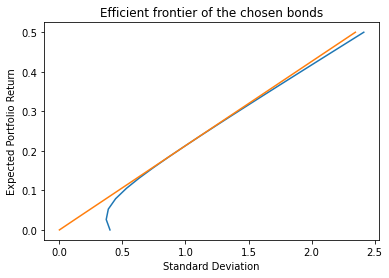

In [10]:
y = np.linspace(0, 0.5, 20)
x =  pow(1/delta +delta/(delta*zeta-alpha*alpha)*(y-Rmv)*(y-Rmv),0.5)
x2 = pow((y-Rf)*(y-Rf)/(zeta-2*alpha*Rf+delta*Rf*Rf),0.5)
plt.plot(x, y)
plt.plot(x2,y)
plt.title('Efficient frontier of the chosen bonds')
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Portfolio Return')
plt.show()

In [11]:
w_star = a+b*Rtg
np.round(w_star,2)

array([-0.26, -0.13, -0.13,  0.46,  0.09, -0.02,  0.68,  0.1 ,  0.3 ,
        0.1 ,  0.07,  0.11, -0.36, -0.09,  0.03,  0.12, -0.12,  0.03])

In [12]:
sharpe = pow(zeta-2*alpha*Rf+delta*Rf**2,0.5)
sharpe

0.21295281206696798

In [13]:
mean = data.mean(axis=0)
covariance_matrix = data.cov()
weights2 = 1/np.random.random(size=(10**5, len(fundcode)))
weights2 /=  np.sum(weights2, axis=1)[:, np.newaxis]
returns = np.dot(weights2, mean)
volatility = []
for i in range(0, len(weights2)):
    volatility.append(np.sqrt(np.dot(weights2[i].T, 
                                    np.dot(covariance_matrix, weights2[i]))))
volatility = np.array(volatility)  
sharpe_ratio = returns / volatility

In [14]:
ex = []
skip = []
ey = np.linspace(returns.min(),returns.max(),1000)
ey = np.round(ey, 2)    
returns = np.round(returns, 2)
for index in range(1000):
    if ey[index] not in returns:
        skip.append(index)
        continue
    index_needed = np.where(returns == ey[index])
    ex.append(np.min(volatility[index_needed]))
ey = np.delete(ey, skip)
ex=np.array(ex)

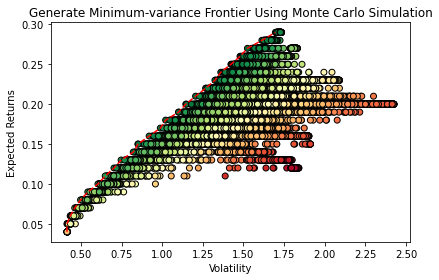

In [15]:
plt.scatter(x=volatility,y= returns,cmap='RdYlGn',c=sharpe_ratio, edgecolors='black')
plt.plot(ex, ey, 'r--')
plt.title("Generate Minimum-variance Frontier Using Monte Carlo Simulation")
plt.xlabel("Volatility")
plt.ylabel("Expected Returns")
plt.tight_layout()
plt.show()

In [16]:
data.columns

Index(['001156', '001410', '001475', '001641', '003625', '004424', '004997',
       '005004', '005827', '005968', '006228', '006751', '110022', '164906',
       '260108', '270042', '519674', '570001'],
      dtype='object', name='基金代码')

In [17]:
np.round(weights2[np.where(sharpe_ratio == max(sharpe_ratio))],2)[0]

array([0.01, 0.  , 0.  , 0.01, 0.01, 0.02, 0.56, 0.01, 0.03, 0.01, 0.31,
       0.01, 0.  , 0.  , 0.  , 0.01, 0.01, 0.  ])

In [18]:
max(sharpe_ratio)

0.17510808212132725

In [19]:
returns[np.where(sharpe_ratio == max(sharpe_ratio))]

array([0.25])

In [20]:
exit()